##  Importing Libraries

In [124]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import matplotlib.image as img
# Keras imports
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM
from keras.models import Model
from tqdm import tqdm
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
import keras


## Data Acquisition
"Using public Dataset"

In [125]:
# This function opens the text path and reads it into a variable
def read_files(file):
    with open(file, 'r') as f:
        captions = f.read()#Read the captions
    captions = captions.split('\n')# Break on rows
    captions = captions[1:-1] #Skip titles
    captions = [caption for caption in captions if caption]#Remove empty strings
    return captions

In [126]:
captions = read_files('captions.txt')#Read the captions.txt file
captions[:5]#print first 5

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']

In [127]:
# This function transforms the captions we read from the .txt file into a dict mapping the image id to the caption
def generate_caption_dict(captions):
    caption_dict = {}
    for caption in tqdm(captions):
        
        aux = caption.split(',')
        caption_dict[aux[0]] = aux[1]
        
    return caption_dict
        
caption_dict = generate_caption_dict(captions)

100%|██████████| 40455/40455 [00:00<00:00, 1124159.06it/s]


two people fly kites in a field


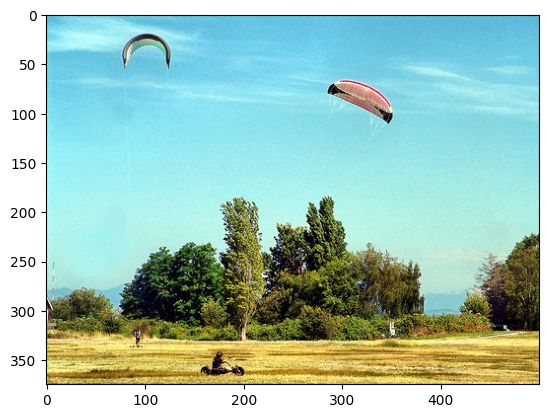

In [128]:
images_dir = 'Images/'
for image in random.sample(list(caption_dict),1):
    plt.figure()
    print(caption_dict[image])
    im = img.imread(images_dir + image)
plt.imshow(im)

## Data Preprocessing

In [129]:
def text_preprocessing(captions):
    captions['caption'] = captions['caption'].apply(lambda x: x.lower())#Convert to lowercase
    captions['caption'] = captions['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))#Delete digits, special chars, etc.,
    captions['caption'] = captions['caption'].apply(lambda x: x.replace("\s+"," "))#Delete additional spaces
    captions['caption'] = captions['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    captions['caption'] = "startseq "+captions['caption']+" endseq"#Add start and end tags to D caption
    return captions

In [130]:
import pandas as pd
# Load the captions data
captions = pd.read_csv("captions.txt")
# Preprocess the captions
preprocessed_captions = text_preprocessing(captions)
# View the preprocessed captions
preprocessed_captions[:10]

,image,caption
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into ...
5,1001773457_577c3a7d70.jpg,startseq black dog and spotted dog are fightin...
6,1001773457_577c3a7d70.jpg,startseq black dog and tri-colored dog playing...
7,1001773457_577c3a7d70.jpg,startseq black dog and white dog with brown sp...
8,1001773457_577c3a7d70.jpg,startseq two dogs of different breeds looking ...
9,1001773457_577c3a7d70.jpg,startseq two dogs on pavement moving toward ea...


In [131]:
#Constanst we will use for our model
config = { 
    'max_vocab': 10000,
    'test_ratio': 0.1,
    'batch_size': 32,
    'steps_per_epoch': 10,
    'epochs': 10,
    'num_classes': 20,
    'max_len': 30
}

Preprocess the captions by tokenizing them and padding them to a fixed length.

In [132]:
# create the captions with start and end tag
y = captions['caption'].apply(lambda x: '<start> ' + x.lower() + ' <end>')
# tokenize the captions
tokenizer = Tokenizer(num_words=config['max_vocab'], 
                      filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
                      oov_token=0)
tokenizer.fit_on_texts(y) 
sequences = tokenizer.texts_to_sequences(y)
# get constant
config['max_len'] = max([len(x) for x in sequences]) 
# pad the sequneces
sequences = pad_sequences(sequences, maxlen=config['max_len'], dtype='int32', padding='post', truncating='post', value=0)
# add sequences to the caption df
captions['sequences'] = sequences.tolist()

## Train/Test split

In [133]:
#with holdout = 20%
random.seed(10)
test_indices = random.sample(list(captions.index), int(config['test_ratio']*captions.shape[0]))
train_indices = [x for x in list(captions.index) if x not in test_indices]

This code defines a function called "data_generator" that takes in three parameters: "pick_from_caption_indices", "batch_size", and "reproduce". The function creates an infinite loop that generates batches of data for training or testing a machine learning model.

The "pick_from_caption_indices" parameter is a list of indices used to select rows from a dataframe called "captions". The "batch_size" parameter determines the number of rows to select for each batch, and the "reproduce" parameter is used to control whether the data generator should randomly select rows or use a fixed seed for reproducibility.

The loop starts by initializing two empty lists, "img_2_arrs" and "one_hot_captions", that will be used to store the images and captions respectively.

Next, the code uses the "random.sample" function to select a random sample of indices from the "pick_from_caption_indices" list. It then uses these indices to select the corresponding rows from the "captions" dataframe.

For each row in the selected rows, the code loads the image, converts it to an array, and normalizes the pixel values by dividing them by 255. It also converts the caption to one-hot encoding using the "to_categorical" function from keras.utils.

Finally, the code appends the image array and the one-hot encoded caption to the respective lists and returns a tuple of numpy arrays containing the images and captions for the current batch.

It also define two variable "train_data_gen" and "test_data_gen" which are generator object of the function data_generator with different arguments and reproduce flag.

In [134]:
# create datagenerator
def data_generator(pick_from_caption_indices, batch_size=32, reproduce=False):
    while True:
        img_2_arrs, one_hot_captions = [], []
        # get the indices
        if reproduce:
            random.seed(1)
        indices = random.sample(pick_from_caption_indices, batch_size)
        # get the relevant rows
        df = captions.loc[indices, ['image', 'sequences']]
        # for each batch size
        for row in df.to_dict(orient='records'):
            # load the image
            image = load_img(f"C:\\Users\\ozexg\\Desktop\\usb\\Dataset\\Images\\{row['image']}", color_mode="rgb", target_size=(229, 229, 3))
            img_2_arr = img_to_array(image) / 255
            one_hot_caption = to_categorical(row['sequences'], num_classes=config['max_vocab'])    
            # append
            img_2_arrs.append(img_2_arr)
            one_hot_captions.append(one_hot_caption)
        # return
        yield np.array(img_2_arrs), np.array(one_hot_captions)

# create the data generators
train_data_gen = data_generator(train_indices, config['batch_size'])
test_data_gen = data_generator(test_indices, 5, True)

## Sequential Model using the Keras library


The CNN part of the model starts with a convolutional layer (Conv2D) with 64 filters, a kernel size of (3,3) and a ReLU activation function. It also has an input shape of (229,229,3) which is the size of the images that the model will be trained on. This is followed by a max pooling layer (MaxPooling2D) with a pool size of (2,2) which reduces the spatial dimensions of the output from the previous layer. This pattern of a Conv2D-MaxPooling2D is repeated several times with the number of filters decreasing with each subsequent layer.

The NLP part of the model starts with a repeat vector layer (RepeatVector) which repeats the input n times where n is the maximum length of the input sequences. This is followed by a LSTM layer (LSTM) with 256 units and the return_sequences parameter set to True. This is followed by a time-distributed dense layer (TimeDistributed) with max_vocab units and a softmax activation function which will output a probability distribution over the vocabulary.

summary of the model architecture, including the number of parameters in each layer.

- Encoder: Custom CNN 
- Decoder: LSTM

In [135]:
from keras import datasets, layers, models
# start
model = models.Sequential()
# CNN part
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(229, 229, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# Flatten
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# NLP part
model.add(layers.RepeatVector(config['max_len']))
model.add(layers.LSTM(256, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(config['max_vocab'], activation='softmax')))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 227, 227, 64)      1792      
                                                                 
 max_pooling2d_108 (MaxPooli  (None, 113, 113, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_109 (Conv2D)         (None, 111, 111, 32)      18464     
                                                                 
 max_pooling2d_109 (MaxPooli  (None, 55, 55, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_110 (Conv2D)         (None, 53, 53, 32)        9248      
                                                                 
 max_pooling2d_110 (MaxPooli  (None, 26, 26, 32)     

In [136]:
# from keras import datasets, layers, models
# model = models.Sequential()
# # CNN part for images
# model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(229, 229, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(16, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(16, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(8, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# # Flatten
# model.add(layers.Flatten())

# # input layer for captions
# caption_input = Input(shape=(config['max_len'],))
# # NLP part for captions
# caption_embedding = Embedding(config['max_vocab'], 256)(caption_input)
# caption_lstm = LSTM(256)(caption_embedding)
# # merge the two inputs
# merged = layers.concatenate([model.output, caption_lstm])
# # output
# out = Dense(config['num_classes'], activation='softmax')(merged)
# # create the final model
# modell = Model(inputs=[model.input, caption_input], outputs=out)
# modell.summary()

## Model Evaluation
we take the validation data and labels to the fit method when we are training the model.

In [139]:
import tensorflow as tf
from keras import optimizers
# define the callbacks
checkpoint = ModelCheckpoint("checkpoint_model_{epoch:02d}.hdf5", monitor='loss', verbose=1,
    save_best_only=False, mode='auto', save_freq=10)
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# # compile the model
model.compile(optimizer='adam', loss="categorical_crossentropy")

 # fit the model
history = model.fit(train_data_gen,epochs=config['epochs'],steps_per_epoch=config['steps_per_epoch'],verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/10
 9/10 [==========================>...] - ETA: 3s - loss: 2.6128
Epoch 1: saving model to checkpoint_model_01.hdf5
10/10 [==============================] - 45s 3s/step - loss: 2.6143
Epoch 2/10
 9/10 [==========================>...] - ETA: 3s - loss: 2.6871
Epoch 2: saving model to checkpoint_model_02.hdf5
10/10 [==============================] - 33s 3s/step - loss: 2.6802
Epoch 3/10
 9/10 [==========================>...] - ETA: 3s - loss: 2.5773
Epoch 3: saving model to checkpoint_model_03.hdf5
10/10 [==============================] - 33s 3s/step - loss: 2.5735
Epoch 4/10
 9/10 [==========================>...] - ETA: 3s - loss: 2.6479
Epoch 4: saving model to checkpoint_model_04.hdf5
10/10 [==============================] - 32s 3s/step - loss: 2.6314
Epoch 5/10
 9/10 [==========================>...] - ETA: 3s - loss: 2.5595
Epoch 5: saving model to checkpoint_model_05.hdf5
10/10 [==============================] - 35s 4s/step - loss: 2.5690
Epoch 6/10
 9/10 [=================

## Calcuate BLEU score(evaluate the quality of the generated captions)

In [140]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [141]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [142]:
def evaluate(model, descriptions, features, tokenizer, max_lenght):
    i = 0
    Actual, Predicted = [],[]
    
    for key, desc_list in tqdm(descriptions.items()):
        y_pred = predict_caption(model, tokenizer, features[key.replace('.jpg', '')], max_lenght)
        y_true = desc_list.split()
        y_pred = y_pred.split()
        Actual.append([y_true])
        Predicted.append(y_pred)
    
    Actual, Predicted = [],[]
    print('BLEU-1: %f' % corpus_bleu(Actual,Predicted , weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(Actual,Predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(Actual, Predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(Actual, Predicted, weights=(0.25, 0.25, 0.25, 0.25)))

## Test Data

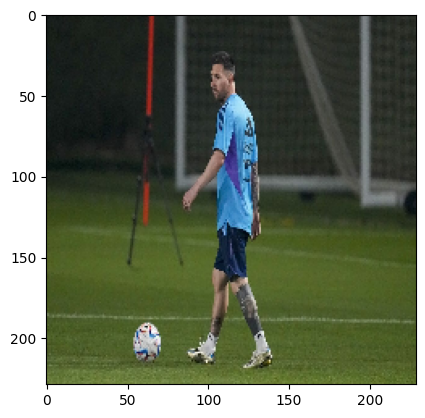

In [145]:
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array

image_path = 'C:\\Users\\ozexg\\Desktop\\usb\\Dataset\\download.jpeg'
image = np.expand_dims(image, axis=0)
image = load_img(image_path, target_size=(229, 229, 3))
image = img_to_array(image) / 255
plt.imshow(image)

# # Convert predicted captions to one-hot encoded form
# predicted_captions = model.predict(image)

# # # Convert one-hot encoded captions to text
# predicted_captions = tokenizer.sequences_to_texts(predicted_captions)

# # # Join predicted captions to form a single sentence
# predicted_caption = " ".join(predicted_captions)


# predicted_captions = [tokenizer[np.argmax(caption)] for caption in predicted_captions]
# preprocessed_captions(image)

# Print predicted caption
# print("Predicted caption: ", predicted_caption)

## Model Deployment

In [ ]:
# from flask import Flask, render_template
# app = Flask(__name__)

# @app.route("/")
# def index():
#     return render_template("index.html")

# if __name__ == "__main__":
#     app.run()